# 1 - Importing Dependecies 

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import pandas as pd
import numpy as np 
import random
import cv2
import os



import time

# 1.1 - Data Pipeline 

In [2]:
os.listdir()

## Data Directory Path
print('#1 - Initialzing DataFrame...\n')
imageID_Path = os.listdir('data/Modern_Contemporary')

## Creating data frame based on directory contents 
imagePath_df = pd.DataFrame({'ID':[n.split('.')[0] for n in imageID_Path],
                                'Path':['data/Modern_Contemporary/' + n for n in imageID_Path]})

## Extracting features of images from the CSV file
csv_dataPath = os.path.join('data/Modern_Contemporary','data.csv')
imageFeatures_df = pd.read_csv(csv_dataPath, sep=',')

## COnvoerting all values to integer values
imagePath_df["ID"]= pd.to_numeric(imagePath_df["ID"],errors='coerce')



## Error handling for none JPEG Images

for i,row in imagePath_df.iterrows():
    picture_Path = row['Path']
    # print(picture_Path)
    extCheck = len(picture_Path)
    path = picture_Path[extCheck-4:]
    if (path != 'JPEG'):
        imagePath_df.drop(i, inplace=True)


print( "Numbers of Images succefully imported:",len(imagePath_df))




#1 - Initialzing DataFrame...

Numbers of Images succefully imported: 1811


In [3]:
merged_df = pd.merge(left=imagePath_df, right=imageFeatures_df, on='ID', how='inner', )

print('Merging Dataframes...')

Merging Dataframes...


In [4]:
merged_df.head()

,ID,Path,Artist,Low Estimation Price,High Estimation Price,Hammer Price,Size,Medium
0,999.0,data/Modern_Contemporary/999.JPEG,Carl Peter Hedelaian,420.0,560.0,1190.0,69cm-141cm(27.17in-55.51in),Oil on canvas
1,998.0,data/Modern_Contemporary/998.JPEG,Tal R,NaN,700.0,448.00000000000006,70cm-100cm(27.56in-39.37in),Silkscreen in colours
2,997.0,data/Modern_Contemporary/997.JPEG,Leif Hoegh,NaN,700.0,378.00000000000006,100cm-80cm(39.37in-31.5in),Oil on panel
3,996.0,data/Modern_Contemporary/996.JPEG,Jane Morten,NaN,700.0,560.0,50cm-60cm(19.68in-23.62in),Acrylic on canvas
4,995.0,data/Modern_Contemporary/995.JPEG,Niels Erik Skovballe,NaN,700.0,420.00000000000006,33cm-24cm(12.99in-9.45in),Oil on plate


In [5]:
len(merged_df)

1811

# 2 - Cleaning Data

In [6]:
## Validating the data
print('Cleaning Data...')


merged_df['Hammer Price'] = pd.to_numeric(merged_df['Hammer Price'], errors='coerce')

merged_df = merged_df.replace(np.nan, 0)

# merged_df['Low Estimation Price'].replace(np.nan, 0)

means = []

for i, row in merged_df.iterrows():

    if(row['Low Estimation Price'] == 0 and row['High Estimation Price'] == 0):
        mean = row['Hammer Price'] / 2
    
    elif (row['Low Estimation Price'] == 0):
        mean = (2*row['High Estimation Price']) / 2
    else:
        mean = (row['Low Estimation Price'] + row['High Estimation Price']) / 2
    means.append(mean)
    if(row['Hammer Price'] == 0.0): 
        merged_df.loc[i, 'Hammer Price'] = mean


# 
merged_df['Mean Estimation'] = pd.Series(means)


Cleaning Data...


In [7]:
print('Normalizing Data...')
CntRem = 0
for i in range(len(merged_df)): 
    if(merged_df.at[i,'Mean Estimation'] > 1000):
        CntRem +=1 
        os.remove(merged_df.at[i,'Path'])
        # merged_df.drop(merged_df.at[merged_df.index[i]], axis=0)

        # print("Image", merged_df.at[i,'ID']," to be removed")

print("Total number of files removed", CntRem)

Normalizing Data...
Total number of files removed 126


# 3 - Loading Images to dataframe

In [8]:
# ##Creating List for Compressed Numpy array data paths
import os.path 



images = []
id = []
IMAGE_RESIZE = (256,256)


for i, row in merged_df.iterrows():

    ## ASsigning iamge path the picture path
    picture_Path = row['Path']
    iD = row = row["ID"]

    if os.path.exists(picture_Path):
        # Reading Image Path, Color Correcting, and then resizing
        pic_bgr_arr = cv2.imread(picture_Path)
        pic_rgb_arr = cv2.cvtColor(pic_bgr_arr, cv2.COLOR_BGR2RGB)
        pic_rgb_arr = cv2.resize(pic_rgb_arr, IMAGE_RESIZE)
        pic_rgb_arr = pic_rgb_arr / 255.0

        # Append to Image List
        images.append(pic_rgb_arr)
        id.append(iD)
    
    else:
        continue
       
    

# ZIP contents to load into datafram
dfData = list(zip(id, images))
images_df = pd.DataFrame(dfData, columns=['ID', 'Image'])


In [9]:
len(images)

1811

In [9]:
# // merging with dataframe
merged_df = pd.merge(left=merged_df, right=images_df, on='ID', how='inner')



In [10]:
merged_df.drop([ 'Medium', 'Size', 'Path', 'ID', 'Artist', 'Low Estimation Price', 'Hammer Price', 'High Estimation Price' ],inplace=True, axis=1)

In [11]:
merged_df.head()

,Mean Estimation,Image
0,490.0,"[[[0.5686274509803921, 0.8235294117647058, 0.8..."
1,700.0,"[[[0.34901960784313724, 0.396078431372549, 0.4..."
2,700.0,"[[[0.10588235294117647, 0.13725490196078433, 0..."
3,700.0,"[[[0.5411764705882353, 0.7254901960784313, 0.6..."
4,700.0,"[[[0.03137254901960784, 0.0392156862745098, 0...."


<AxesSubplot:>

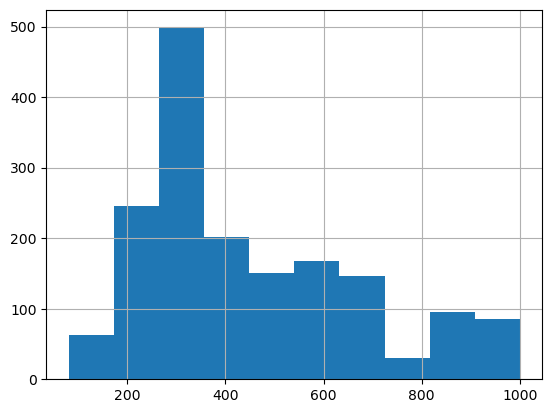

In [12]:
merged_df['Mean Estimation'].hist()

# 4 Normalizing

In [13]:
# from sklearn.preprocessing import MinMaxScaler 

# scaler = MinMaxScaler()




# merged_df['Mean Estimation'] = scaler.fit(merged_df['Mean Estimation'])

meanAvg = merged_df['Mean Estimation'].mean()
meanDev = merged_df['Mean Estimation'].std()
meanMax = merged_df['Mean Estimation'].max()
meanMin = merged_df['Mean Estimation'].min()



print(meanAvg)
print(meanDev)
print(meanMax)


for i in range(len(merged_df)):
    merged_df.loc[i, 'Mean Estimation'] = np.log(merged_df.at[i, 'Mean Estimation'])
#     merged_df.loc[i, 'Mean Estimation'] = merged_df.at[i, 'Mean Estimation'] / 100.0


# # merged_df.loc[i, 'Mean Estimation'] = (merged_df.at[i, 'Mean Estimation'] - meanAvg) / meanDev



# merged_df.head()

449.5240356083086
222.8503443918832
1000.0


<AxesSubplot:>

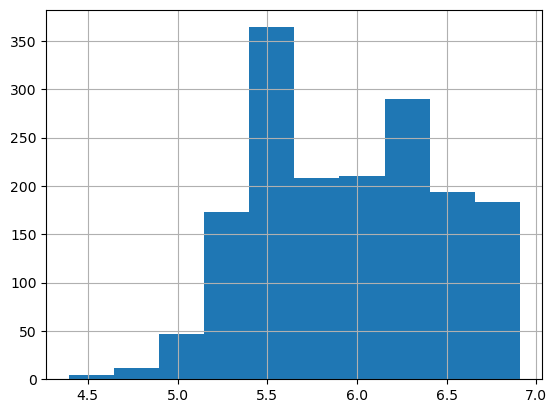

In [14]:
merged_df['Mean Estimation'].hist()

In [15]:
# merged_df.drop([ 'Low Estimation Price', 'High Estimation Price',],inplace=True, axis=1)
# merged_df.drop([ 'Hammer Price'],inplace=True, axis=1)

In [15]:
merged_df.head()

,Mean Estimation,Image
0,6.194405,"[[[0.5686274509803921, 0.8235294117647058, 0.8..."
1,6.551080,"[[[0.34901960784313724, 0.396078431372549, 0.4..."
2,6.551080,"[[[0.10588235294117647, 0.13725490196078433, 0..."
3,6.551080,"[[[0.5411764705882353, 0.7254901960784313, 0.6..."
4,6.551080,"[[[0.03137254901960784, 0.0392156862745098, 0...."


In [20]:

shuffled_df = merged_df.sample(frac=1)



train_df, val_df, test_df = shuffled_df[:1340], shuffled_df[1340:1600], shuffled_df[1600:]

len(train_df), len(val_df), len(test_df)


(1340, 260, 85)

In [21]:
train_df.head()

,Mean Estimation,Image
1250,5.857933,"[[[0.2980392156862745, 0.4823529411764706, 0.3..."
1038,6.040255,"[[[0.9254901960784314, 0.9176470588235294, 0.8..."
270,5.501258,"[[[0.8352941176470589, 0.8549019607843137, 0.8..."
947,6.194405,"[[[0.5686274509803921, 0.5176470588235295, 0.4..."
1415,5.857933,"[[[0.8509803921568627, 0.26666666666666666, 0...."


In [22]:


def get_X_y(df):

    dfArr = np.array(df)

    x_pic = []
    y_medium = []

    for i in range(len(df)): 

        estimation = dfArr[i, 0]
        y_medium.append(estimation)

        pic = dfArr[i, 1]
        x_pic.append(pic)

    X_pic = np.asarray(x_pic)
    Y_medium = np.asarray(y_medium)


    return X_pic, Y_medium  



In [23]:
X_train_pic, Y_train_est = get_X_y(train_df)

X_val_pic,  Y_val_est = get_X_y(val_df)

X_test_pic, Y_test_est = get_X_y(test_df)

In [24]:
# Y_train_art[0]
X_train_picTensor = tf.convert_to_tensor(X_train_pic, dtype="float32")
Y_trainEstTensor = tf.convert_to_tensor(Y_train_est, dtype="float32")

X_val_picTensor = tf.convert_to_tensor(X_val_pic, dtype="float32")
Y_valEstTensor = tf.convert_to_tensor(Y_val_est, dtype="float32")

valData = [X_val_picTensor, Y_valEstTensor]


# 5 - Modeling

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import tensorflow as tf

In [41]:
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# MaxPool condesing wach 2x2 patch and taking max value
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128,  (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))


model.add(Conv2D(64,  (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64,  (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_1 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 254, 254, 32)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 252, 252, 128)     36992     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 126, 126, 128)    

In [44]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(x = X_train_pic, y = Y_train_est, epochs=3, validation_data=valData, callbacks=[tensorboard_callback])

Epoch 1/3
 5/42 [==>...........................] - ETA: 7:14 - loss: 4628.7334 - accuracy: 0.0000e+00

KeyboardInterrupt: 

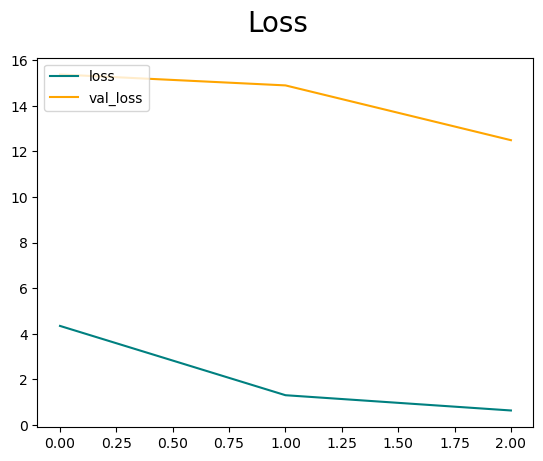

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

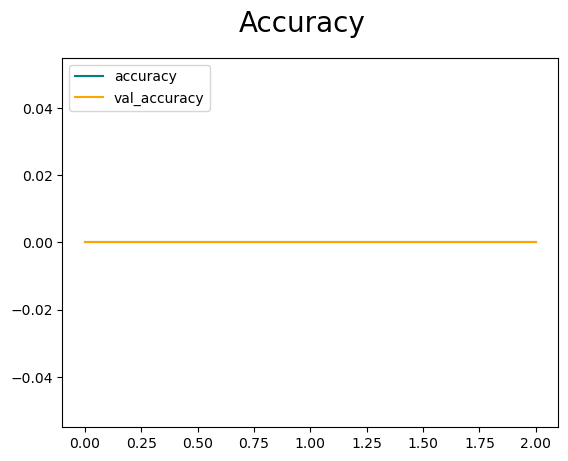

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [34]:
results = model.predict(X_test_pic)

3/3 [==============================] - 4s 1s/step


In [36]:
results = 10**results

In [39]:
Y_test_est = 10**Y_test_est 


In [40]:
Y_test_est

array([2127829.29481397,  720996.49667103, 7098799.78526157,
        431310.07519054,  603592.05668205,  431310.07519054,
         87426.36517613,  720996.49667103,  431310.07519054,
       3556971.08720944,  222386.04472836,  222386.04472836,
        222386.04472836,  431310.07519054, 1097121.46307219,
       5412549.63279696,  317145.24952481,  431310.07519054,
        431310.07519054, 1564607.44013887, 7718849.47167222,
        146145.67716932, 2127829.29481397, 2127829.29481397,
       2127829.29481397, 1097121.46307219, 5412549.63279696,
        720996.49667103,  222386.04472836, 1097121.46307219,
       3271242.13041477, 1097121.46307219,  720996.49667103,
       2127829.29481397, 1564607.44013887,  720996.49667103,
       2790742.84133503,  720996.49667103,  720996.49667103,
        720996.49667103, 7718849.47167222, 1097121.46307219,
       7718849.47167222,  222386.04472836, 2790742.84133503,
        720996.49667103,  860784.01934546, 1097121.46307219,
        431310.07519054,